# Timoshenko Beam Control

In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

In [2]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(2*'../') # go n dirs back
from src import *
from dicts import *
from timoshenko_utils import *

In [3]:
# Change device according to your configuration
# device = torch.bdevice('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

### Load Timoshenko Beam

In [4]:
# Load discretization data
A = torch.load('A_sys').to(device).float()
B = torch.load('B_sys').to(device).float()
x0 = torch.load('x0')[None].to(device).float()
x_dim, u_dim = x0.shape[1], 2

u = BoxConstrainedController(x_dim, u_dim, h_dim=512, num_layers=3).to(device)

f = TimoshenkoBeam(A, B, u).to(device)

In [5]:
class HyperNet(nn.Module):
    """Simple hypernetwork for controlled systems
    Input: current x, f and u from the controlled system
    Output: p-th order residuals"""
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def forward(self, t, x):
        xfu = torch.cat([x, f.cur_f, f.cur_u], -1)
        return self.net(xfu)
# hdim = 256
# snake_activation = Snake(hdim)
hypersolver = torch.load('saved_models/hypersolver_0.005_256_snake_rw_layers_2_new.pt')

In [6]:
u_low = torch.Tensor([-1, -1]).to(device)
u_high = torch.Tensor([1, 1]).to(device)
u_dist = torch.distributions.Uniform(u_low, u_high)
f.u = RandConstController()

f.u.u0 = u_dist.sample((1,)) # set  random controller to be common for all experiments
t0, tf, dt = 0, 3, 0.005
steps = int((tf - t0)/dt) + 1
t = torch.linspace(t0, tf, steps)

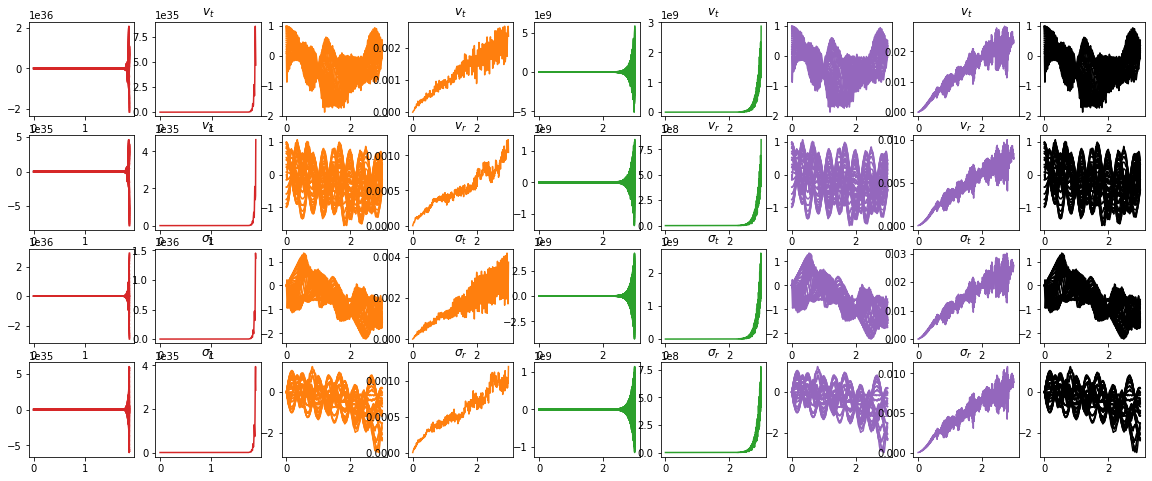

In [7]:
plot_test(f, x0, t, hypersolver)

## Plot SMAPE propagation with random controllers


In [8]:
t0, tf, dt = 0, 3, 0.005
bs = 1024
steps = int((tf - t0)/dt) + 1
t = torch.linspace(t0, tf, steps)
x0_batch = x0.repeat(bs, 1, 1).to(device).squeeze(1)
u_rand = RandConstController()
u_rand.u0 = u_dist.sample((bs,))
# print(u_rand)
f = TimoshenkoBeam(A, B, u_rand).to(device)

x_eu = odeint(f.to(device), x0_batch.to(device), t, solver='euler')[1].detach().cpu()
x_he = odeint(f.to(device), x0_batch.to(device), t, solver=hypersolver)[1].detach().cpu()
x_mp = odeint(f.to(device), x0_batch.to(device), t, solver='midpoint')[1].detach().cpu()
x_rk4 = odeint(f.to(device), x0_batch.to(device), t, solver='rk4')[1].detach().cpu()
xT = odeint(f.to(device), x0_batch.to(device), t, solver='tsit5', atol=1e-5, rtol=1e-5)[1].detach().cpu()
uT = f.u(0, xT.to(device)).repeat(xT.shape[0], 1, 1)

NameError: name 'nums' is not defined

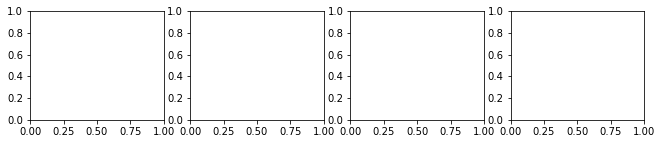

In [9]:
v_t_nom, v_r_nom, sig_t_nom, sig_r_nom = divide_timoshenko_variables(xT[:,0,:])
trajs = [x_eu, x_he, x_mp, x_rk4, xT]
titles = ['Euler', 'HyperEuler', 'Midpoint', 'RK4']
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:purple', 'black']

fig, axs = plt.subplots(1, 4, figsize=(11, 2))
for traj, title, color, i in zip(trajs, titles, colors, nums):
    v_t, v_r, sig_t, sig_r = divide_timoshenko_variables(traj[:,0,:])\

    # Error propagation
    err_v_t = MAE_on_dim(v_t, v_t_nom)
    err_v_r = MAE_on_dim(v_r, v_r_nom)
    err_sig_t = MAE_on_dim(sig_t, sig_t_nom)
    err_sig_r = MAE_on_dim(sig_r, sig_r_nom)
    
    axs[0].plot(t.cpu(), err_v_t, color=color, label=title);
    axs[1].plot(t.cpu(), err_v_r, color=color);
    axs[2].plot(t.cpu(), err_sig_t, color=color);
    axs[3].plot(t.cpu(), err_sig_r, color=color);
    
    axs[0].set_title(r'$v_t$')
    axs[1].set_title(r'$v_r$')
    axs[2].set_title(r'$\sigma_t$')
    axs[3].set_title(r'$\sigma_r$')
    
for ax in axs:
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1e9)
    ax.set_xlabel(r'$t~[s]$', labelpad=-3)
    ax.set_ylabel(r'$MAE$')
    ax.label_outer()
    
axs[0].legend(loc='upper center', bbox_to_anchor=(2.28, -0.21),
          fancybox=True, shadow=False, ncol=4)
# Saving
import tikzplotlib
fig.savefig('media/timoshenko_error_propagation.pdf', bbox_inches='tight')
tikzplotlib.save("media/timoshenko_error_propagation.tex")

In [ ]:
# def smape_random_walk(x0, dt, t0=0, tf=5, steps_min=1, steps_max=200,
#                 bs=64, solver='rk4'):
#     '''
#     We generate initial positions by random propagation of the initial position over time:
#         1. Start with a batch of the same initial conditions
#         2. Generate batched random controllers
#         3. Propagate them forward by a random time 
#         4. Add the new positions to the positions batch via concatenation
#         5. Reiterate from 2) until the random time in 3) in more than $t_f$, final time to end the simulation
#     '''
#     t_checkpoint = 0
#     x0_batch = x0.repeat(bs, 1, 1).to(device).squeeze(1)
#     x0_checkpoint = x0_batch
#     u_batch = None
    
#     # End the simulation if it has reached the end time
#     while t_checkpoint <= tf:
#         # Random times
#         tf_checkpoint = uniform(t_checkpoint+steps_min*dt, t_checkpoint+steps_max*dt) # number of steps for final checkpoint time
#         steps = int((tf_checkpoint - t_checkpoint)/dt) + 1
#         t = torch.linspace(t_checkpoint, tf_checkpoint, steps)

#         # Generate intial states with random controllers
#         u_rand.u0 = u_dist.sample((bs,))
#         f.u = u_rand
        
#         # Random walk
#         x0_checkpoint = odeint(f, x0_checkpoint, t, solver=solver)[1][-1]
        
#         # Add the initial positions and to the batch
#         x0_batch = torch.cat([x0_batch, x0_checkpoint], dim=0)
        
#         # Increase time 
#         t_checkpoint = tf_checkpoint
        
#     return x0_batch

### Test controller with nominal trajectory

In [10]:
# Parameters

t = torch.linspace(0, 3, 300+1)

def plot_test_controller(f, x0, 
                         span=torch.linspace(0, 5, 500+1), 
                         title='Euler trajectories and control policy'):
    _, xT = odeint(f.to(device), x0.to(device), t, solver='tsit5', atol=1e-5, rtol=1e-5)
    xT = xT.detach().cpu()
    uT = f.u(0, xT.to(device))

    v_t = xT[:,0,dofs_dict['v_t']]
    v_r = xT[:,0,dofs_dict['v_r']]
    sig_t = xT[:,0,dofs_dict['sig_t']]
    sig_r = xT[:,0,dofs_dict['sig_r']]

    fig, axs = plt.subplots(3, 1, figsize=(10, 5))
    axs[0].plot(t.cpu(), v_t, ':k');
    axs[0].plot(t.cpu(), v_r, 'b');
    axs[1].plot(t.cpu(), sig_t, ':k');
    axs[1].plot(t.cpu(), sig_r, 'b');
    axs[2].plot(t.cpu(), uT[:,0,:].detach().cpu(), ':b');
    fig.suptitle(title)
    return xT

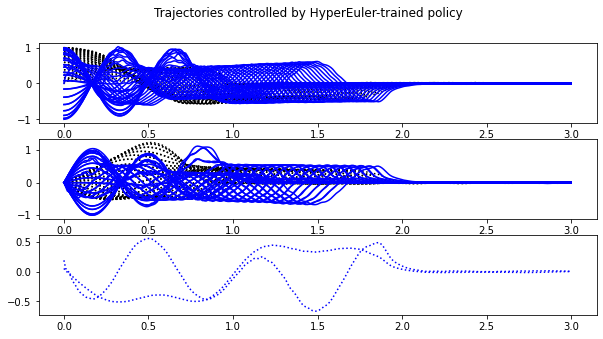

In [11]:
f.u = torch.load('saved_models/u_hypersolver.pt')
xT_hyper = plot_test_controller(f, x0, span = t, title='Trajectories controlled by HyperEuler-trained policy')

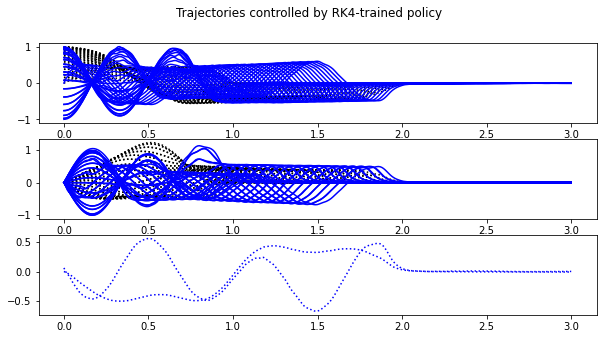

In [12]:
f.u = torch.load('saved_models/u_rk4.pt')
xT_rk4 = plot_test_controller(f, x0, title='Trajectories controlled by RK4-trained policy')

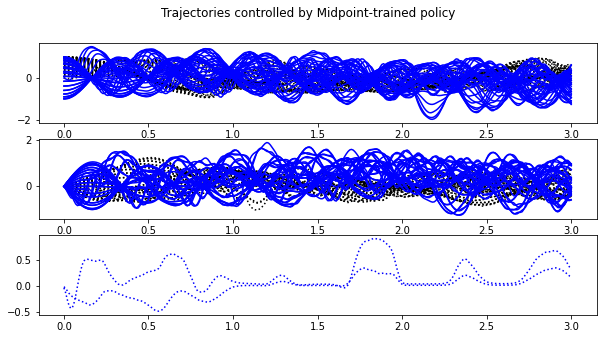

In [13]:
f.u = torch.load('saved_models/u_midpoint.pt')

xT_midpoint = plot_test_controller(f, x0, t, title='Trajectories controlled by Midpoint-trained policy')

Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True)
Parameter containing:
tensor([nan, nan, nan,  ..., nan, nan, nan], requires_grad=True)
Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True)
Parameter containing:
tensor([nan, nan, nan,  ..., nan, nan, nan], requires_grad=True)
Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
  

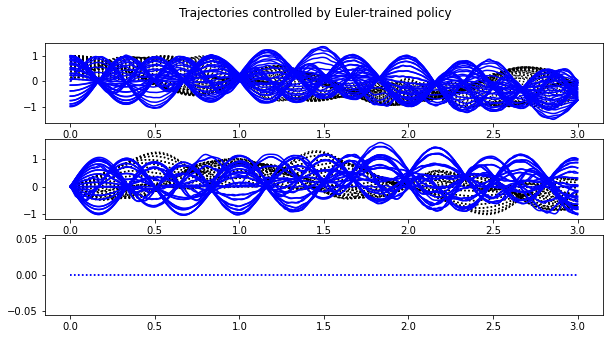

In [14]:
# Check the controller trained with Euler
f.u = torch.load('saved_models/u_euler.pt')
for p in f.u.parameters():
    print(p)
    
# From the first training path before, we saw the loss was NaN on the first try
# Since it did not properly, we will consider the controller as the initial one
f.u = BoxConstrainedController(160, 2, h_dim=512, num_layers=3, constrained=True).to(device)
xT_euler = plot_test_controller(f, x0, title='Trajectories controlled by Euler-trained policy')

We see that Euler has failed to train the policy due to the problem's stiffness and has filled the controller with `NaN` values

In [15]:
def loss_function(x, u):
    control_loss = torch.norm(x[:,0,dofs_dict['sig_t']], p=2, dim=-1).mean()
    control_loss = control_loss + torch.norm(x[:,0,dofs_dict['sig_r']], p=2, dim=-1).mean()
    reg_loss = 1e-3*u(0., x).abs().mean()
    loss = control_loss + reg_loss
    return loss

print(loss_function(xT_hyper, torch.load('saved_models/u_hypersolver.pt')))
print(loss_function(xT_euler, torch.load('saved_models/u_euler.pt')))
print(loss_function(xT_midpoint, torch.load('saved_models/u_midpoint.pt')))
print(loss_function(xT_rk4, torch.load('saved_models/u_rk4.pt')))

tensor(2.7046, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(6.2215, grad_fn=<AddBackward0>)
tensor(2.6874, grad_fn=<AddBackward0>)


We also see how the quality of the controller is very close to RK4

## Errors on final positions

In [16]:
def print_errors_finite_elements(x, message):
    print('\n========= Finite elements state final errors =================')
    print(message)
    print(r'Mean error : {} ± {}'.format(round(np.mean(x), 5), round(np.std(x), 4)))

print_errors_finite_elements(xT_hyper[-1,0,:].detach().numpy(), 'HyperEuler')
print_errors_finite_elements(xT_euler[-1,0,:].detach().numpy(), 'Euler')
print_errors_finite_elements(xT_midpoint[-1,0,:].detach().numpy(), 'Midpoint')
print_errors_finite_elements(xT_rk4[-1,0,:].detach().numpy(), 'RK4')


========= Finite elements state final errors =================
HyperEuler
Mean error : -0.0006300000241026282 ± 0.004900000058114529

========= Finite elements state final errors =================
Euler
Mean error : -0.2819100022315979 ± 0.42170000076293945

========= Finite elements state final errors =================
Midpoint
Mean error : -0.004490000195801258 ± 0.45809999108314514

========= Finite elements state final errors =================
RK4
Mean error : -0.000590000010561198 ± 0.0032999999821186066


In [17]:

plt.style.use('dark_background')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [18]:
## Training times

def print_train_times(exp, message):
    file = open("results/"+exp+"_times.txt", "r")
    training_times = [float(item) for item in file.read().splitlines()[0].split(',')]
    print('\n==========================')
    print(message)
    print(r'Mean runtime : {} ± {} s'.format(round(np.mean(training_times), 4), round(np.std(training_times), 4)))
    print(r'Total runtime : {} s'.format(round(np.sum(training_times), 2)))

print_train_times('hypersolver', 'HyperEuler training times')
print_train_times('euler', 'Euler training times')
print_train_times('midpoint', 'Midpoint training times')
print_train_times('rk4', 'RK4 training times')


HyperEuler training times
Mean runtime : 2.5257 ± 0.0934 s
Total runtime : 2523.19 s

Euler training times
Mean runtime : 2.0104 ± 0.0398 s
Total runtime : 2008.39 s

Midpoint training times
Mean runtime : 4.0204 ± 0.0879 s
Total runtime : 4016.36 s

RK4 training times
Mean runtime : 8.2435 ± 0.1443 s
Total runtime : 8235.21 s


## Plot comparisons with displacements $\sigma_t$ and $\sigma_r$

In [20]:
    v_t = xT[:,0,dofs_dict['v_t']]


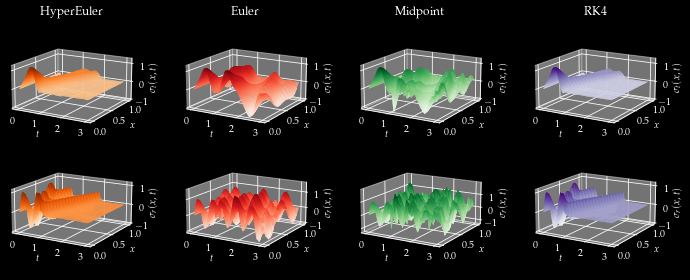

In [21]:
# Ordering
x_v_t = x_dict['v_t'].cpu()
x_v_r = x_dict['v_r'].cpu()
x_sig_t = x_dict['sig_t'].cpu()
x_sig_r = x_dict['sig_r'].cpu()

# Get beam positions
pos_v_t = x_v_t.repeat(t.shape[0], 1)
pos_v_r = x_v_r.repeat(t.shape[0], 1)
pos_sig_t = x_sig_t.repeat(t.shape[0], 1)
pos_sig_r = x_sig_r.repeat(t.shape[0], 1)

# Time collocation
times = t[:,None].repeat(1, v_t.shape[-1])


# Aspect of each plot
x_scale = 1
y_scale = 1
z_scale = .5

# Plotting
fig, axs = plt.subplots(2,4,figsize=(10,4), subplot_kw=dict(projection='3d'),  constrained_layout=False)
                        
def plot_timoshenko_3D(ax, traj, cmap='Oranges', title='HyperEuler'):
    v_t, v_r, sig_t, sig_r = divide_timoshenko_variables(traj)
    
    def plot_var(ax, pos, var, label=f'$v_t$'):
        ax.plot_surface(times.numpy(), pos.numpy(), var.numpy(), cmap=cmap, rstride=1, cstride=1, rasterized=True)
        ax.set_xlabel(f'$t$', labelpad=-4)
        ax.set_ylabel(f'$x$', labelpad=-4)
        ax.set_zlabel(label, labelpad=-8)
        ax.view_init(15, -60)
        ax.set_xticks([0, 1 , 2, 3])
        ax.set_yticks([0, 0.5, 1])
        ax.set_zticks([-1, 0, 1])
        ax.set_box_aspect([x_scale, y_scale, z_scale])
        ax.tick_params(axis='both', which='major', pad=-2)
        
    plot_var(ax[0], pos_sig_t, sig_t, label=f'$\sigma_t(x, t)$')
    plot_var(ax[1], pos_sig_r, sig_r, label=f'$\sigma_r(x, t)$')
    
    ax[0].set_title(title, family='cursive')
#     title = ax[0].title
#     title.set_position([0.5, 1.2])
    return ax

plot_timoshenko_3D(axs[:,0], xT_hyper[:,0,:], 'Oranges', 'HyperEuler')
plot_timoshenko_3D(axs[:,1], xT_euler[:,0,:], 'Reds', 'Euler')
plot_timoshenko_3D(axs[:,2], xT_midpoint[:,0,:], 'Greens', 'Midpoint')
plot_timoshenko_3D(axs[:,3], xT_rk4[:,0,:], 'Purples', 'RK4')


fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=-.03)

# Saving
import tikzplotlib
fig.savefig('media/timoshenko_control_3d.png', transparent = True, bbox_inches='tight')
# tikzplotlib.save("media/timoshenko_control_3d.tex")

In [24]:
fig.savefig('media/timoshenko_control_3d.png', transparent = True, bbox_inches='tight', dpi=600)


## Plots

In [ ]:
# Plot last positions
xT = xT_hyper

v_t = xT[:,0,dofs_dict['v_t']].cpu()
v_r = xT[:,0,dofs_dict['v_r']].cpu()
sig_t = xT[:,0,dofs_dict['sig_t']].cpu()
sig_r = xT[:,0,dofs_dict['sig_r']].cpu()

x_v_t = x_dict['v_t'].cpu()
x_v_r = x_dict['v_r'].cpu()
x_sig_t = x_dict['sig_t'].cpu()
x_sig_r = x_dict['sig_r'].cpu()


fig, axs = plt.subplots(2, 2)
axs[0,0].scatter(x_v_t, v_t[-1])
axs[0,1].scatter(x_v_r, v_r[-1])
axs[1,0].scatter(x_sig_t, sig_t[-1])
axs[1,1].scatter(x_sig_r, sig_r[-1])
axs[0,0].scatter(x_v_t, v_t[0])
axs[0,1].scatter(x_v_r, v_r[0])
axs[1,0].scatter(x_sig_t, sig_t[0])
axs[1,1].scatter(x_sig_r, sig_r[0])

axs[1,0].set_ylim([-.1, .1])
axs[1,1].set_ylim([-.1, .1])

## Complexity and FLOPS calculation

In [ ]:
from ptflops import get_model_complexity_info

bs = 1 # batch size we used in training
def get_macs(net:nn.Module):
    params = []
    for p in net.parameters(): params.append(p.shape)
    with torch.cuda.device(0):
        macs, _ = get_model_complexity_info(net, (bs, params[0][1]), as_strings=False)
    return int(macs)

controller_test = nn.Sequential(
                nn.Linear(160, 1024),
                nn.Softplus(),
                nn.Linear(1024, 1024),
                nn.Softplus(),
                nn.Linear(1024, 1024),
                nn.Tanh(),
                nn.Linear(1024, 2))

hypersolver_test = nn.Sequential(nn.Linear(322, 256), nn.Softplus(), nn.Linear(256, 256), 
                                 nn.Softplus(), nn.Linear(256, 160)).to(device)

hs_macs = get_macs(hypersolver_test)
u_macs = get_macs(controller_test)

print('Controller MACs per NFE:', u_macs, '\nHypersolver MACs per NFE:', hs_macs)

In [ ]:
unit_mac_hyper = u_macs + hs_macs
unit_mac_euler = u_macs
unit_mac_midpoint = u_macs*2 # midpoint has to evaluate the vector field twice per NFE
unit_mac_rk4 = u_macs*4 # rk4 has to do it 4 times

In [ ]:
multiplier = 2 # mac to flops
macs_hyper = unit_mac_hyper*multiplier
macs_euler = unit_mac_euler*multiplier
macs_midpoint = unit_mac_midpoint*multiplier
macs_rk4 = unit_mac_rk4*multiplier

In [ ]:
# # losses from above
# # Flops are 2*GMACs
# # https://github.com/sovrasov/flops-counter.pytorch/issues/16

print('HyperEuler FLOPs:', macs_hyper)
print('Euler FLOPs:', macs_euler)
print('Midpoing FLOPs:', macs_midpoint)
print('RK4 FLOPs:', macs_rk4)


In [ ]:
# Ratio
print('Hyper vs euler:', macs_hyper/macs_euler*100, '%')
print('Hyper vs RK4:', -(1 - (macs_hyper/macs_rk4))*100, '%')